<a href="https://colab.research.google.com/github/Yi-Wei-Lin/Tibame_ML_20210602/blob/main/DL_TL_dogs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import io,os
import numpy as np
import pandas as pd

In [2]:
import json

In [3]:
kaggle_json = {"username":"twyiweilin","key":"58a1caf3d6bee0e188c5978f4763ea4d"}

In [4]:
os.makedirs('/content/.kaggle/',exist_ok=True)

In [5]:
os.makedirs('/root/.kaggle/',exist_ok=True)

In [6]:
with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(kaggle_json, file)

In [7]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [8]:
!kaggle competitions download -c dogs-vs-cats

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 26.8MB/s]
 96% 259M/271M [00:03<00:00, 75.8MB/s]
100% 271M/271M [00:04<00:00, 70.3MB/s]
 97% 527M/543M [00:03<00:00, 168MB/s]
100% 543M/543M [00:04<00:00, 137MB/s]


In [9]:
!unzip /content/train.zip
!unzip /content/test1.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           
  inflating: test1/5520.jpg  

In [48]:
from keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(244,244,3)) #不包括大腦 / 偷來的 model 設計是224
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 244, 244, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0     

In [49]:
import glob
import pandas as pd
# 先不讀取圖片, 真的要訓練才讀
df = pd.DataFrame(columns=["path", "target"])
for p in glob.glob("train/cat.*.jpg"):
  s = pd.Series([p, 0], index=["path", "target"])
  df = df.append(s, ignore_index=True)
for p in glob.glob("train/dog.*.jpg"):
  s = pd.Series([p, 1], index=["path", "target"])
  df = df.append(s, ignore_index=True)
df

,path,target
0,train/cat.12298.jpg,0
1,train/cat.9752.jpg,0
2,train/cat.4100.jpg,0
3,train/cat.9568.jpg,0
4,train/cat.5878.jpg,0
...,...,...
24995,train/dog.2963.jpg,1
24996,train/dog.3470.jpg,1
24997,train/dog.9075.jpg,1
24998,train/dog.8138.jpg,1


train/cat.7471.jpg
(499, 454)


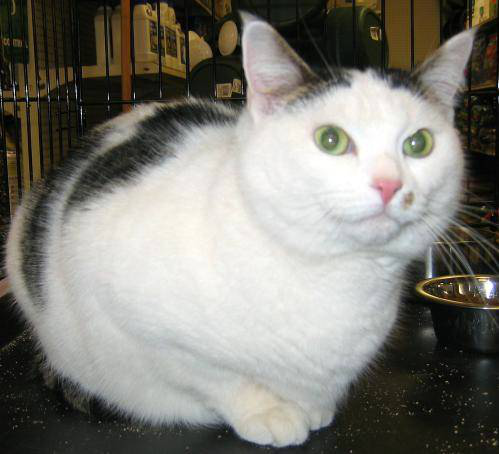

In [50]:
from keras.preprocessing.image import load_img
import random
c = random.randint(0, 24999)
print(df["path"][c])
img = load_img(df["path"][c])
print(img.size)
img

(244, 244)


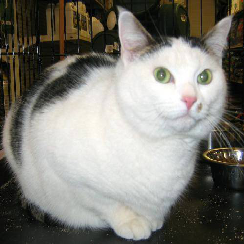

In [51]:
img = load_img(df["path"][c], target_size=(244,244))
print(img.size)
img

In [52]:
from keras.models import Model
from keras.layers import Dense, Flatten
for l in vgg.layers:
  l.trainable=False # 固定參數(偷來的)
# vgg.output
x = Flatten()(vgg.output)
x = Dense(units=2048, activation="relu")(x)
x = Dense(units=256, activation="relu")(x)
# 貓和狗分類 : units = 1, units = 2 都可以
#       : sigmoid  , softmax  
x = Dense(units=2, activation="softmax")(x)
cnn = Model(inputs=vgg.input, outputs=x)
cnn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 244, 244, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0   

In [53]:
vgg.layers

In [54]:
cnn.compile(loss="categorical_crossentropy",
      optimizer="adam",
      metrics=["accuracy"])

In [55]:
from sklearn.model_selection import train_test_split
# 真的要開始切分和訓練的時候, 請你把你的pandas轉成numpy的array
#先處理一下答案, 把她轉換成為 one-hot encoding
from keras.utils.np_utils import to_categorical
y_cat = to_categorical(df["target"])
import numpy as np
x_train, x_test, y_train, y_test = train_test_split(np.array(df["path"]),
                    np.array(y_cat),
                    test_size=0.1)
y_train[0]

array([0., 1.], dtype=float32)

In [56]:
# 你偷誰的模型, 就要使用他的預處理方式
from keras.applications.vgg16 import preprocess_input
batch_size = 20
for i in range(5):
  # randint(下限(包括), 上限(不包括), 幾個)
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  # numpy好用之處: array[ 索引list ]  這樣一次可以拿很多個
  imglist = []
  for fn in x_train[idx]:
    # 讀取圖片並且使用我們偷來的模型的預處理方式來處理一下
    img = load_img(fn, target_size=(244,244))
    img = preprocess_input(np.array(img))
    imglist.append(img)
  x = np.array(imglist)
  y = y_train[idx]
  result = cnn.train_on_batch(x, y)
  print("-----Times:", i, "-----")
  print(result)

-----Times: 0 -----
[13.72477912902832, 0.30000001192092896]
-----Times: 1 -----
[251.73648071289062, 0.44999998807907104]
-----Times: 2 -----
[1.7015835046768188, 0.8999999761581421]
-----Times: 3 -----
[80.26669311523438, 0.75]
-----Times: 4 -----
[64.34773254394531, 0.6000000238418579]


In [58]:
batch_size = 200
# randint(下限(包括), 上限(不包括), 幾個)
idx = np.random.randint(0, x_test.shape[0], batch_size)
# numpy好用之處: array[ 索引list ]  這樣一次可以拿很多個
imglist = []
oriimglist = []
for fn in x_test[idx]:
  # 讀取圖片並且使用我們偷來的模型的預處理方式來處理一下
  img = load_img(fn, target_size=(244,244))
  # 先把原圖留下來
  oriimglist.append(img)
  img = preprocess_input(np.array(img))
  imglist.append(img)
x = np.array(imglist)
y = y_test[idx]
cnn.evaluate(x, y)


7/7 [==============================] - 18s 839ms/step - loss: 3.7314 - accuracy: 0.9550


[3.7314200401306152, 0.9549999833106995]